<h1 align="center">Numerical Methods for</h1>
<h1 align="center">Heston Model in Option Pricing</h1>

<h3 align="center">YuHsuan Shih, ys2898  | Francis Chen, hc2857 </h3> 

## 1. Introduction

The Heston Model in Finance, named after Steven Heston [1], is a stochastic mathematical model, describing the evolution of volatility and price of an underlying asset, which extends the famous Black-Scholes model by allowing volatility to follow a mean reverting stochastic process. Heston model is commonly used in option pricing, especially for European option, which can only be exercised at the maturity. 

For better understanding, we'd like to introduce some basic logics about the financial derivative: option. "A call option gives the holder the right to buy the underlying asset
by a certain date for a certain price. A put option gives the holder the right to sell the underlying asset by a certain date for a certain price." [2]

The payoff of an European call and put option is given by:

$$
\text{Call Option Payoff } = (S_T - K)^+ \qquad \text{Put Option Payoff } = (K - S_T)^+
$$

The option price is the certain fee that the buyer should pay for entering the contract. Because the expected return of an option is always non-negative, by the fundamental theorem of asset pricing, the arbitrage-free condition must be satisfied. Simply speaking, no "free lunch" could exist in the market. Including the option price, the profit and loss curve is shown as follows [2]:

![Option P&L](./images/payoff.jpg)

Generally, we are interested in applying numerical methods to solve the Heston model and find the fair price of a given European option. 

### 1.1 Mathematical Model
In Heston Model, the stock price and volatility are assumed to follow two different stochastic processes [1]:

$$
\text{Stock Price: }\quad dS_t = \mu S_t\, dt + \sqrt{V_t}S\, dW^1_t
$$

$$
\text{Volatility: }\quad dV_t = \kappa(\theta - V_t)\, dt + \sigma\sqrt{V_t}\, dW^2_t
$$

where $W^1$ and $W^2$ are two correlated Wiener Processes(continuous Brownian Motion), with correlation $\rho$: $dW^1\, dW^2 = \rho\, dt$. 

By derivation (under risk-neutral measure), the stochastic model can be generated to a Partial Differential Equation for the function of option price, volatility of the stock, ant the time to maturity $U(S,v,t)$ [3]:

$$
\frac{\partial U}{\partial t} = \frac 1 2 v S^2 \frac{\partial^2 U}{\partial S^2} + \rho\sigma v S \frac{\partial^2 U}{\partial U\partial v} + \frac 1 2 \sigma^2v\frac{\partial^2 U}{\partial v^2} + (r-q)S\frac{\partial U}{\partial S} + \kappa(\theta - v)\frac{\partial U}{\partial v} - rU
$$

where,
$$\begin{aligned}
&t: \text{time to maturity}\\
&v: \text{variance/volatility of the stock}\\
&S: \text{stock price}\\
&\rho : \text{correlation between two Brownian Motions}\\
&\sigma: \text{the volatility of } v\\
&r: \text{interest rate}\\
&q: \text{continuously compounded dividend rate}\\
&\kappa: \text{mean reverting rate of } v\\
&\theta: \text{long run mean of } v\\
&2\kappa\theta > \sigma^2: \text{to assure positive } v
\end{aligned}$$

For European call option, Heston PDE is subject to the following boundary conditions:

$$\begin{aligned}
U(S,v,0) &= (S-K)^+ \\
U(0,v,t) &=0 \\
\lim_{S\to\infty} \frac{\partial U}{\partial s}(S,v,t) &= 1\\
(r-q)S\frac{\partial U}{\partial S}(S,0,t) + \kappa\theta\frac{\partial U}{\partial v}(S,0,t) - rU(S,0,t) - \frac{\partial U}{\partial t}(S,0,t) &= 0\\
\lim_{v\rightarrow\infty} U(S,v,t) & = S
\end{aligned}$$

where $K$ is the pre-determined strike price.

### 1.2 Closed form solution
Heson(1993) provided a closed form solution for this PDE in pricing European call option:
$$
U(S,v,t) = Se^{-qt} P_1 - Ke^{-rt}P_2
$$

where $U(S,v,t)$ is the call option price at current time, and $t$ is the time to maturity. 

For $j=1,2$:
$$
P_j = \frac 1 2 + \frac 1 \pi \int_0^{\infty} Re\left( \frac{e^{-i\phi\ln(K)} f_j}{i\phi}\right) d\phi \\
$$

$$
f_j = \exp \left( A_j+B_jv+i\phi\ln(S)\right)
$$

$$
A_j = r\phi i\tau + \frac{\kappa\theta}{\sigma^2}\left[ (b_j-\rho\sigma\phi i+d)\tau-2\ln\left( \frac{1-g_je^{dr}}{1-g_j}\right) \right]
$$

$$
B_j = \frac{b_j-\rho\sigma\phi i+d_j}{\sigma^2} \left(\frac{1-e^{d_j\tau}}{1-g_je^{d_j\tau}} \right) \\
$$

$$
g_j = \frac{b_j-\rho\sigma\phi i+d_j}{b_j-\rho\sigma\phi i-d_j}\\
$$

$$
d_j = \sqrt{( \rho\sigma\phi i-b_j)^2-\sigma^2(2\mu_j\phi i-\phi^2)}
$$

where,
$$
\tau=t,\ \ u_1 = \frac 1 2, \ \ u_2 = -\frac 1 2, \ \ b_1 = \kappa-\rho\sigma,\ \ b_2=\kappa
$$

** Code Implementation**

In [1]:
%matplotlib inline
%precision 16
import numpy 
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
# Integration
from scipy.integrate import quad
# 3D plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# Monte Carlo
import numpy.random as rnd

In [2]:
def Heston_Integral(phi, rho, sigma, r, kappa, theta, _lambda, v, S, tau, K, j):

    u_1 = 0.5
    u_2 = - 0.5
    a = kappa * theta
    rspi = rho * sigma * phi * 1j
    
    b_1 = kappa + _lambda - rho * sigma
    b_2 = kappa + _lambda
    
    d_1 = numpy.sqrt((rspi - b_1)**2 - sigma**2 * (2.0 * u_1 * phi * 1j - phi**2))
    d_2 = numpy.sqrt((rspi - b_2)**2 - sigma**2 * (2.0 * u_2 * phi * 1j - phi**2))
    
    g_1 = (b_1 - rspi + d_1) / (b_1 - rspi - d_1)
    g_2 = (b_2 - rspi + d_2) / (b_2 - rspi - d_2)
   
    D_1 = (b_1 - rspi + d_1) / sigma**2 * ((1.0 - numpy.exp(d_1 * tau)) / (1.0 - g_1 * numpy.exp(d_1 * tau)))
    D_2 = (b_2 - rspi + d_2) / sigma**2 * ((1.0 - numpy.exp(d_2 * tau)) / (1.0 - g_2 * numpy.exp(d_2 * tau)))
    
    C_1 = r * phi * 1j * tau + a / sigma**2 * ((b_1 - rspi + d_1) * tau - 2.0 * numpy.log((1.0 - g_1 * numpy.exp(d_1 * tau))/(1.0 - g_1)))
    C_2 = r * phi * 1j * tau + a / sigma**2 * ((b_2 - rspi + d_2) * tau - 2.0 * numpy.log((1.0 - g_2 * numpy.exp(d_2 * tau))/(1.0 - g_2)))   
    
    if(S > 0):
        f_1 = numpy.exp(C_1 + D_1 * v + 1j * phi * numpy.log(S))
        f_2 = numpy.exp(C_2 + D_2 * v + 1j * phi * numpy.log(S))
    elif(S == 0):
        f_1 = 0.0
        f_2 = 0.0
    elif(S < 0):
            raise NotImplementedError()
    
    if(j==1):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_1)/(1j * phi))
    elif(j==2):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_2)/(1j * phi))

# The closed-form solution for Heston PDE
def Heston_ExactSolution(rho, sigma, r, kappa, theta, _lambda, V, S, T, K):
    
    if(S < 0):
        raise NotImplementedError()
    elif(S == 0): 
        Call = 0.0
    elif(S > 0):
        P_1 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 100, args=(rho, sigma, r, kappa, theta, _lambda, V, S, T, K, 1))[0]
        P_2 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 100, args=(rho, sigma, r, kappa, theta, _lambda, V, S, T, K, 2))[0]
        Call = S * P_1 - K * numpy.exp(- r * T) * P_2
    return Call

**Test**

In [3]:
K = 100.0
S = 100.0
V = 0.04
T = 0.25
r = 0.03
kappa = 2.0
theta = 0.20
sigma = 0.3
rho = -0.5
_lambda = 0.02
print "Test call option price: ", Heston_ExactSolution(rho, sigma, r, kappa, theta, _lambda, V, S, T, K)

Test call option price:  5.74042230856


**Solution Plot**

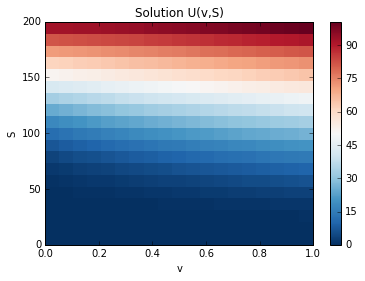

In [4]:
K = 100.0; rho = 0.8; sigma = 0.3; r = 0.03; kappa = 2.0; theta = 0.2; _lambda = 0.00
T = 1.0; t = 0.0

v = numpy.linspace(0, 1.0, 20)
s = numpy.linspace(0, 200.0, 20)

X, Y = numpy.meshgrid(v, s)

z = numpy.array([Heston_ExactSolution(rho, sigma, r, kappa, theta, _lambda, v, s, T, K)\
                 for v, s in zip(numpy.ravel(X), numpy.ravel(Y))])
U_exact = z.reshape([20,20])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(X, Y, U_exact, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)

## 2. Numerical Methods

### 2.1 Method of lines
#### Discretization: Space

* For the first and second derivatives $\rightarrow$ Use the central finite difference approximations
* For the cross derivatives $\rightarrow$ Use the second order approximation in both $S$ and $v$

$$
\begin{align}
\left(\frac{\partial U}{\partial S}\right)_{i,j} &\approx \frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}\\
\left(\frac{\partial U}{\partial v}\right)_{i,j} &\approx \frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}\\
\left(\frac{\partial^2 U}{\partial S^2}\right)_{i,j} &\approx \frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{\Delta S^2}\\
\left(\frac{\partial^2 U}{\partial v^2}\right)_{i,j} &\approx \frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{\Delta v^2}\\
\left(\frac{\partial^2 U}{\partial S\partial v}\right)_{i,j} &\approx \frac{U_{i+1, j+1} - U_{i-1,j+1} - U_{i+1,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v}
\end{align}
$$

$$
\begin{align}
\frac{dU_{i,j}}{dt} &= (S_i)^2v_j\frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{2\Delta S^2}+ \rho\sigma S_iv_j\frac{U_{i+1, j+1} - U_{i-1,j} - U_{i,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v}\\ 
&+ \sigma^2v_j\frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{\Delta v^2}+rS_i\frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}+\kappa(\theta-v_j)\frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}-rU_{i,j}
\end{align}
$$

Note that there is a mixed derivative term in this PDE, we are using a **9-point stencil**. If written in a matrix form, the sparsity of the matrix should be like this:

<img src="./images/9-point_stencil.png" style="max-width:100%; width: 25%">

#### Discretization: Time 
For time discretization, we have implemented three different schemes.

### 2.1.1 Explicit Scheme (Forward Euler method)
#### Update formula
$$
    U^{n+1}=AU^{n}+rhs
$$

In forward euler method, the value of the function which is used to approximate the time derivative is evaluated at time $t_n$:

$$\begin{aligned}
    U^{n+1}_{i,j} = & \ U^{n}_{i,j} + \Delta t \left\{ (S_i)^2v_j\frac{U^n_{i+1, j} - 2U^n_{i,j} + U^n_{i-1,j}}{2\left(\Delta S\right)^2} \right.\\
    & \qquad\qquad + \rho\sigma S_iv_j\frac{U^n_{i+1, j+1} - U^n_{i-1,j+1} - U^n_{i+1,j-1}+U^n_{i-1,j-1}}{4\Delta s\Delta v}  \\
    & \qquad\qquad + \sigma^2v_j\frac{U^n_{i, j+1} - 2U^n_{i,j} + U^n_{i,j-1}}{2\left(\Delta v\right)^2}\\
    & \qquad\qquad + rS_i\frac{U^n_{i+1, j} - U^n_{i-1,j}}{2\Delta S} \\
    & \qquad\qquad + \left. \kappa(\theta-v_j)\frac{U^n_{i, j+1} - U^n_{i,j-1}}{2\Delta v}-rU^n_{i,j} \right\}
\end{aligned}$$

Then we can write this explicit finite difference scheme as:

$$
    U^{n+1}_{i,j} = a_{i,j} U^n_{i-1,j-1}+ b_{i,j} U^n_{i-1,j} + c_{i,j} U^n_{i-1, j+1} + d_{i,j} U^n_{i, j-1} + e_{i,j} U^n_{i, j} + f_{i,j} U^n_{i, j+1} + g_{i,j} U^n_{i+1, j-1} + h_{i,j} U^n_{i+1, j} + k_{i,j} U^n_{i+1, j+1}
$$

, where
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = \frac{\rho\sigma\Delta t}{4\Delta S\Delta v} S_i v_j\\
    b_{i,j} &= \Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} - \frac{rS_i}{2\Delta S}\right)\\
    d_{i,j} &= \Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 - \Delta t\left(r + \frac{S_i^2v_j}{\left(\Delta S\right)^2} + \frac{\sigma^2v_j}{\left(\Delta v\right)^2}\right)\\
    f_{i,j} &= \Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= \Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} + \frac{rS_i}{2\Delta S}\right)\\
\end{align}
$$

#### Boundary condition
Let the grid be $U_{i,j}$, $i=0,\dots, N-1$, $j=0,\dots, M-1$
* **Lower BC**: $S = 0$, $U(0,v,t) = 0$
$$U_{0,j} = 0$$

* **Upper BC**: $S \to \infty$, $\lim_{S\to\infty} \frac{\partial U}{\partial s}(S,v,t) = 1$
  
  Use one sided second ordered approximation: 
  $$
    \frac{3U_{N-1,j} -4U_{N-2, j} + U_{N-3,j}}{2\Delta S} = 1
  $$
  
  Get, 
  $$
    U_{N-1,j} = \frac{2\Delta s + 4U_{N-2,j} - U_{N-3,j}}{3}
  $$
* **Left BC**: $v = 0$, $rS\frac{\partial U}{\partial S}(S,0,t) + \kappa\theta\frac{\partial U}{\partial v}(S,0,t) - rU(S,0,t)-\frac{\partial U}{\partial t}(S,0,t) = 0$
  
  This boundary condition is the most complicated one. Here, we use **implicit scheme** and **first order approximation of spatial derivative** to discretize it:
  
  $$U^{n+1}_{i,0} = U^n_{i,0} + \Delta t\left(rS_0\frac{U^{n+1}_{i,j} + U^{n+1}_{i-1,j}}{\Delta S} - \kappa\theta\frac{U^{n+1}_{i,1} - U^{n+1}_{i,0}}{\Delta v} - rU^{n+1}_{i,0}\right)\\
\Rightarrow\left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)U^{n+1}_{i,0} = U^n_{i,0} - rS_i\frac{\Delta t}{\Delta s} U^{n+1}_{i-1,0} + \kappa\theta\frac{\Delta t}{\Delta v}U^{n+1}_{i,1}
  $$
* **Right BC**: $v \to \infty$, $\lim_{v\to\infty}U(S,v,t) = S$
  $$U_{i,M-1} = S_i
  $$

**Code Implementation**

To make our life easier, we restrict ourself to have a domain whose lower boundary variables are all 0, i.e. $U(S,v,t):[0,S]\times[0,v]\times[0,T]\rightarrow \mathbb{R}$. Therefore, we can further reduce the value of the element in our matrix by $S_i = i\Delta S,~v_j = j\Delta v$:
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = \frac{\rho\sigma\Delta t}{4} ij\\
    b_{i,j} &= \Delta t\left(\frac{i^2v_j}{2} - \frac{ri}{2}\right)\\
    d_{i,j} &= \Delta t\left(\frac{\sigma^2j}{2\Delta v} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 - \Delta t\left(r + i^2v_j+ \frac{\sigma^2j}{\Delta v}\right)\\
    f_{i,j} &= \Delta t\left(\frac{\sigma^2j}{2\Delta v} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= \Delta t\left(\frac{i^2v_j}{2} + \frac{ri}{2}\right)\\
\end{align}
$$

In [5]:
def construct_A_rhs_forward(rho, sigma, r, kappa, theta, M, N, delta_v, delta_s, delta_t, v, s):
    A = numpy.zeros([M*N, M*N])
    rhs = numpy.zeros(M*N)
    
    for irow in range(M*N):
        # U_hat[irow] == U(i,j)
        i = irow/M
        j = numpy.mod(irow, M)

        if( i == 0 or i == N-1 or j == 0 ):
            continue
        elif (j == M-1):
            rhs[irow] = s[i]
        else:
            temp = rho*sigma*i*j*delta_t/4.0
            A[irow, irow - M - 1] = temp #a 
            A[irow, irow - M ]    = 0.5 * delta_t * (i**2 * v[j] - r*i) #b
            A[irow, irow - M + 1] = -temp #c
            A[irow, irow - 1]     = 0.5 * delta_t/delta_v * (sigma**2 * j - kappa*(theta - v[j])) #d
            A[irow, irow]         = 1 - delta_t * (r + i**2 * v[j] + sigma**2 * j/delta_v) #e
            A[irow, irow + 1]     = 0.5 * delta_t/delta_v * (sigma**2 * j + kappa*(theta - v[j])) #f
            A[irow, irow + M - 1] = -temp #g
            A[irow, irow + M]     = 0.5 * delta_t * (i**2 * v[j] + r*i) #h
            A[irow, irow + M + 1] = temp #k
    return A, rhs

In [6]:
def solve_heston_forward(rho, sigma, r, kappa, theta, M, N, V, S, T, K):
    
    delta_s = S/(N-1)
    delta_v = V/(M-1)
    
    s = numpy.linspace(0.0, S + 20*delta_s, N+20)
    v = numpy.linspace(0.0, V + 20*delta_v, M+20)
    
    N = N+20
    M = M+20
    L = N*100
    
    t = numpy.linspace(0.0, T, L)
    delta_t = t[1] - t[0]
    
    U_old = numpy.zeros(M*N)
    U_new = numpy.zeros(M*N)

    for i in range(N):
        U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)
    A_f, rhs_f = construct_A_rhs_forward(rho, sigma, r, kappa, theta, M, N, delta_v, delta_s, delta_t, v, s)
    
    for timestep in t:  
        U_new = numpy.dot(A_f, U_old)
        
        ## BC at v[-1]
        U_new += rhs_f

        ## BC at s = S[-1]
        U_new[(N-1)*M: N*M] = (2*delta_s + 4.0*U_new[(N-2)*M: (N-1)*M] - U_new[(N-3)*M: (N-2)*M])/3.0

        ## BC at v = v[0]
        for i in xrange(N):
            if i == 0:
                continue
            U_new[i*M] = ( U_old[i*M] - r*i*delta_t*U_new[(i-1)*M] + kappa*theta*delta_t*U_new[i*M + 1] / delta_v )\
                        / ( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t )
        U_old = numpy.copy(U_new)
    return numpy.reshape(U_new, [N, M]), s, v

**Test**

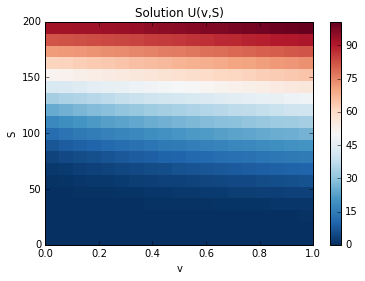

In [7]:
# Set Coefficient
rho = 0.8; sigma = 0.3; r = 0.03; kappa = 2.0; theta = 0.2

K = 100.0

# Set domain: [0,S] x [0,V] x [0,T]
S = 200.0
V = 1.0
T = 1.0

# Discretize domain
M = 20
N = 20
    
U_forward, s, v = solve_heston_forward(rho, sigma, r, kappa, theta, M, N, V, S, T, K)
E, X = numpy.meshgrid(v[:-20], s[:-20])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_forward[:-20,:-20], cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)

### 2.1.2 Implicit Scheme (Backward Euler method)

#### Update formula 
$$
    AU^{n+1}=U^{n}+rhs
$$

In backward euler method, the value of the function which is used to approximate the time derivative is evaluated at time $t_{n+1}$:
$$\begin{aligned}
    U^{n+1}_{i,j} = & \ U^{n}_{i,j} + \Delta t \left\{ (S_i)^2v_j\frac{U^{n+1}_{i+1, j} - 2U^{n+1}_{i,j} + U^{n+1}_{i-1,j}}{2\left(\Delta S\right)^2} \right.\\
    & \qquad\qquad + \rho\sigma S_iv_j\frac{U^{n+1}_{i+1, j+1} - U^{n+1}_{i-1,j+1} - U^{n+1}_{i+1,j-1}+U^{n+1}_{i-1,j-1}}{4\Delta s\Delta v}  \\
    & \qquad\qquad + \sigma^2v_j\frac{U^{n+1}_{i, j+1} - 2U^{n+1}_{i,j} + U^{n+1}_{i,j-1}}{2\left(\Delta v\right)^2}\\
    & \qquad\qquad + rS_i\frac{U^{n+1}_{i+1, j} - U^{n+1}_{i-1,j}}{2\Delta S} \\
    & \qquad\qquad + \left. \kappa(\theta-v_j)\frac{U^{n+1}_{i, j+1} - U^{n+1}_{i,j-1}}{2\Delta v}-rU^{n+1}_{i,j} \right\}
\end{aligned}$$

Then we can write this implicit finite difference scheme as:
$$a_{i,j} U^{n+1}_{i-1,j-1}+ b_{i,j} U^{n+1}_{i-1,j} + c_{i,j} U^{n+1}_{i-1, j+1} + d_{i,j} U^{n+1}_{i, j-1} + e_{i,j} U^{n+1}_{i, j} + f_{i,j} U^{n+1}_{i, j+1} + g_{i,j} U^{n+1}_{i+1, j-1} + h_{i,j} U^{n+1}_{i+1, j} + k_{i,j} U^{n+1}_{i+1, j+1} = U^{n}_{i,j}$$
, where
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = -\frac{\rho\sigma\Delta t}{4\Delta S\Delta v} S_i v_j\\
    b_{i,j} &= -\Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} - \frac{rS_i}{2\Delta S}\right)\\
    d_{i,j} &= -\Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 + \Delta t\left(r + \frac{S_i^2v_j}{\left(\Delta S\right)^2} + \frac{\sigma^2v_j}{\left(\Delta v\right)^2}\right)\\
    f_{i,j} &= -\Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= -\Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} + \frac{rS_i}{2\Delta S}\right)\\
\end{align}
$$

#### Boundary condition
Since we are implementing an implicit scheme, unlike explicit one that we can simply impose them after updating, some of the boundary condition may affect the value of the element in the matrix A, some may be reflected in the right hand side.

* **Lower BC**: $S = 0$ **[Ignore]**
  $$U_{0,j} = 0,~for~j=0,\dots,M-1$$
  
* **Upper BC**: $S \to \infty$ **[Implement both in the matrix and the right hand side]**
  
  For $j=1,\dots, M-2$
  $$\begin{align}U^{n+1}_{N-1,j} &= \frac{2\Delta s + 4U^{n+1}_{N-2,j} - U^{n+1}_{N-3,j}}{3}\\
  &= \frac 4 3U^{n+1}_{N-2,j} - \frac 1 3 U^{n+1}_{N-3,j} + \frac{2\Delta s}{3}\end{align}$$
    
* **Left BC**: $v = 0$ **[Implement in the right hand side]**
  
  Same as discussed in forward euler method, we have:
  $$\left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)U^{n+1}_{i,0} =U^{n}_{i,0} - \frac{rS_i\Delta t}{\Delta s} U^{n+1}_{i-1,0} + \frac{\kappa\theta\Delta t}{\Delta v} U^{n+1}_{i,1}\\
\Rightarrow ri\Delta t U^{n+1}_{i-1,0} + \left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)U^{n+1}_{i,0} - \frac{\kappa\theta\Delta t}{\Delta v} U^{n+1}_{i,1}=U^{n}_{i,0}$$ for $i=1,...,N-2$, For $i=0$, we use the boundary condition for $S=0$, $U_{0,0}=0$. 
  
  But since we can't get $U^{n+1}_{i,1}$ at this moment, we change to use $U^{n}_{i,1}$ instead of $U^{n}_{i,1}$:
$$ri\Delta t U^{n+1}_{i-1,0} + \left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)U^{n+1}_{i,0}=U^{n}_{i,0} + \frac{\kappa\theta\Delta t}{\Delta v} U^{n+1}_{i,1}$$
Further, since we know the value of $U^{n+1}_{0,0}$, we can simply calculate $U^{n+1}_{i,0}$, $i=1, \dots $ by
$$U^{n+1}_{i,0}= \frac{U^{n}_{i,0} + \frac{\kappa\theta\Delta t}{\Delta v} U^{n+1}_{i,1} - ri\Delta t U^{n+1}_{i-1,0}}{\left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)}$$
Therefore allow us to treat this boundary condition in the right hand side.

* **Right BC**: $v \to \infty$ **[Implement in the right hand side]**
$$U_{i,M-1} = S_i,~for~i=0,\dots,N-1$$

**Code Implementation**

Again, we can reduce the discretization scheme to ($S_i = i\Delta S;~v_j = j\Delta v$):
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = -\frac{\rho\sigma\Delta t}{4} ij\\
    b_{i,j} &= -\Delta t\left(\frac{i^2v_j}{2} - \frac{ri}{2}\right)\\
    d_{i,j} &= -\Delta t\left(\frac{\sigma^2j}{2\Delta v} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 + \Delta t\left(r + i^2v_j+ \frac{\sigma^2j}{\Delta v}\right)\\
    f_{i,j} &= -\Delta t\left(\frac{\sigma^2j}{2\Delta v} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= -\Delta t\left(\frac{i^2v_j}{2} + \frac{ri}{2}\right)\\
\end{align}
$$

In [8]:
def construct_A_rhs_backward(rho, sigma, r, kappa, theta, M, N, delta_v, delta_s, delta_t, v, s):
    A = numpy.zeros([M*N, M*N])
    rhs = numpy.zeros(M*N)
    # Construct matrix A
    for irow in range(M*N):
        i = irow/M + 1
        j = numpy.mod(irow, M) + 1

        temp = rho*sigma*i*j*delta_t/4.0
        a = -temp
        k = -temp
        c = temp
        g = temp
        b = -0.5 * delta_t * (i**2 * v[j-1] - r*i)
        d = -0.5 * delta_t/delta_v * (sigma**2 * j - kappa*(theta - v[j-1]))
        e = 1 + delta_t * (r + i**2 * v[j-1] + sigma**2 * j/delta_v)
        f = -0.5 * delta_t/delta_v * (sigma**2 * j + kappa*(theta - v[j-1]))
        h = -0.5 * delta_t * (i**2 * v[j-1] + r*i)

        i = i-1
        j = j-1

        if( i == 0 ):
            if( j==0 ):
                A[irow, irow]         = e
                A[irow, irow + 1]     = f
                A[irow, irow + M]     = h
                A[irow, irow + M + 1] = k
            elif( j==M-1 ):
                A[irow, irow - 1]     = d
                A[irow, irow]         = e
                A[irow, irow + M - 1] = g
                A[irow, irow + M]     = h
                rhs[irow]             = -k*s[i+1] - f *s[i] 
            else:
                A[irow, irow - 1]     = d
                A[irow, irow]         = e
                A[irow, irow + 1]     = f
                A[irow, irow + M - 1] = g
                A[irow, irow + M]     = h
                A[irow, irow + M + 1] = k
        elif (i == N-1):
            if( j==0 ):
                A[irow, irow - M ]    = b - h*1.0/3.0
                A[irow, irow - M + 1] = c - k*1.0/3.0
                A[irow, irow]         = e + h*4.0/3.0 
                A[irow, irow + 1]     = f + k*4.0/3.0
                rhs[irow]             = -2.0/3.0*delta_s*(h+k)
            elif( j==M-1 ):
                A[irow, irow - M - 1] = a - g*1.0/3.0
                A[irow, irow - M ]    = b - h*1.0/3.0
                A[irow, irow - 1]     = d + g*4.0/3.0
                A[irow, irow]         = e + h*4.0/3.0 
                rhs[irow]             = -(c*s[i-1] + f *s[i] + k*S)- 2.0/3.0*delta_s*(g+h)
            else:
                A[irow, irow - M - 1] = a - g*1.0/3.0
                A[irow, irow - M ]    = b - h*1.0/3.0
                A[irow, irow - M + 1] = c - k*1.0/3.0
                A[irow, irow - 1]     = d + g*4.0/3.0
                A[irow, irow]         = e + h*4.0/3.0 
                A[irow, irow + 1]     = f + k*4.0/3.0
                rhs[irow]             = -2.0/3.0*delta_s*(h+k+g)
        else:
            if( j==0 ):
                A[irow, irow - M ]    = b
                A[irow, irow - M + 1] = c
                A[irow, irow]         = e
                A[irow, irow + 1]     = f
                A[irow, irow + M]     = h
                A[irow, irow + M + 1] = k
            elif( j==M-1 ):
                rhs[irow]             = -( s[i-1] * c + s[i] * f + s[i+1] * k )
                A[irow, irow - M - 1] = a  
                A[irow, irow - M ]    = b
                A[irow, irow - 1]     = d
                A[irow, irow]         = e
                A[irow, irow + M - 1] = g
                A[irow, irow + M]     = h            
            else:
                A[irow, irow - M - 1] = a  
                A[irow, irow - M ]    = b
                A[irow, irow - M + 1] = c
                A[irow, irow - 1]     = d
                A[irow, irow]         = e
                A[irow, irow + 1]     = f
                A[irow, irow + M - 1] = g
                A[irow, irow + M]     = h
                A[irow, irow + M + 1] = k
    return A, rhs

In [9]:
def solve_heston_backward(rho, sigma, r, kappa, theta, M, N, V, S, T, K):
    delta_s = S/(N+1)
    delta_v = V/(M+1)
    
    s = numpy.linspace(0.0, S + 20*delta_s, N+20+2)
    v = numpy.linspace(0.0, V + 20*delta_v, M+20+2)
    
    N = N+20
    M = M+20
    L = int(M)
    t = numpy.linspace(0.0, T, L)
    
    s = s[1:-1]
    v = v[1:-1]
    
    delta_t = t[1] - t[0]
    
    U_old = numpy.zeros(M*N)
    U_new = numpy.zeros(M*N)
    U_bc  = numpy.zeros(N+2)
    
    # Initialize U vector
    U_bc[0]  = 0
    U_bc[-1] = numpy.maximum(S - K, 0.0)
    
    for i in range(N):
        U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)
        U_bc[i] = numpy.maximum(s[i] - K, 0.0)

    A_b, rhs_b = construct_A_rhs_backward(rho, sigma, r, kappa, theta, M, N, delta_v, delta_s, delta_t, v, s)
    
    temp = numpy.empty(N+2)
    temp[0] = 0.0
    for timestep in t:

        for i in xrange(N+2):
            if i == 0:
                continue       
            else:
                if i == N+1:
                    temp1 = (2.0*delta_s + 4.0 * U_old[(i-2)*M]- U_old[(i-3)*M] )/3.0
                else:
                    temp1 = U_old[(i-1)*M]
                temp[i] = ( U_bc[i] - r*i*delta_t*temp[i-1] + kappa*theta*delta_t*temp1/delta_v )\
                          /( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t )
                U_bc = numpy.copy(temp)

        # a, d, g
        for i in xrange(N):
            temp2 = rho*sigma*(i+1)*delta_t/4.0
            a = -temp2
            d = -0.5 * delta_t/delta_v * (sigma**2- kappa*(theta - v[0]))
            g = temp2
            rhs_b[i*M] = -a*temp[i] -d*temp[i+1] -g*temp[i+2]
        U_new = numpy.linalg.solve(A_b, U_old+rhs_b)
        U_old = numpy.copy(U_new)
        
    U = numpy.zeros([N+2,M+2])
    U[1:-1, 1:-1] = numpy.reshape(U_new, [N, M])
    U[0, :] = numpy.ones(M+2) * 0.0
    for i in xrange(N+2):
        if i == 0:
            continue       
        else:
            if i == N+1:
                temp1 = (2.0*delta_s + 4.0 * U_old[(i-2)*M]- U_old[(i-3)*M] )/3.0
            else:
                temp1 = U_old[(i-1)*M]
            temp[i] = ( U_bc[i] - r*i*delta_t*temp[i-1] + kappa*theta*delta_t*temp1/delta_v )\
                      /( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t )
            U_bc = numpy.copy(temp)
            
    U[:,0] = numpy.copy(U_bc)
    
    U[-1,-1] = S-K
    U[0,-1] = 0
    U[1:-1, -1] = s - numpy.ones(N)*K
    U[-1,:] = (2*delta_s*numpy.ones(M+2) + 4.0*U[-2, :] - U[-3, :])/3.0
    
    return U, numpy.linspace(0.0, S + 20*delta_s, N+2), numpy.linspace(0.0, V + 20*delta_v, M+2)

**Test**

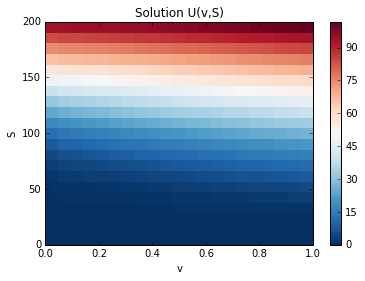

In [11]:
#Set coefficient
rho = 0.8; sigma = 0.3; r = 0.03; kappa = 2.0; theta = 0.2

K = 100.0

# Set domain: [0,S] x [0,V] x [0,T]
S = 200.0
V = 1.0
T = 1.0

M = 20
N = 20

U_backward, s_b, v_b = solve_heston_backward(rho, sigma, r, kappa, theta, M, N, V, S, T, K)
X, Y = numpy.meshgrid(v_b[:-20], s_b[:-20])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(X, Y, U_backward[:-20, :-20], cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)

### 2.1.3 Modified Backward Euler Method
Here, we proposed a method that is basically same as the backward euler but with a different way to deal with the boundary condition, which makes this implementation not fully implicit.

To explain the algorithm, we can categorize our grid points into three different classes:
* Boundary points (Orange circle)
* Interior point whose nine points stencil involve boundary points (Green circle)
* Interior point whose nine points stencil does not involve boundary points (Red circle)

<img src="https://docs.google.com/a/columbia.edu/drawings/d/1mze__LmZaa6K9cJD-Mdf1Jk7upz0hjN4NnZ71HQ-sZ4/pub?w=285&h=238">

#### Case 1:
For the interior point whose nine points stencil doesn't involve boundary points, i.e. $U_{i,j}$, $i=2,\dots, N-3$, $j=2,\dots, M-3$,we use traditional backward euler method:
$$
    a_{i,j} U^{n+1}_{i-1,j-1}+ b_{i,j} U^{n+1}_{i-1,j} + c_{i,j} U^{n+1}_{i-1, j+1} + d_{i,j} U^{n+1}_{i, j-1} + e_{i,j} U^{n+1}_{i, j} + f_{i,j} U^{n+1}_{i, j+1} + g_{i,j} U^{n+1}_{i+1, j-1} + h_{i,j} U^{n+1}_{i+1, j} + k_{i,j} U^{n+1}_{i+1, j+1} = U^{n}_{i,j}
$$
, the value of $a_{i,j},b_{i,j},c_{i,j},d_{i,j},e_{i,j},f_{i,j},g_{i,j},h_{i,j},k_{i,j}$ are same as those in backward euler method but don't need to modify to handle the boundary condition.
#### Case 2 :
Here is the place that things get tricky. In this method, we **update the interior points and boundary points seperately**, which allows us to treat the boundary condition as a dirichlet type and the boundary points' value we are from the previous time step.

Take $U_{1,1}$ as an example (where $U_{0,0}, U_{0,1}, U_{0,2}, U_{1,0}, U_{2,0}$ are boundary points), its updating rule becomes:
$$a_{1,1} U^{n}_{0,0}+ b_{1,1} U^{n}_{0,1} + c_{1,1} U^{n}_{0, 2} + d_{1,1} U^{n}_{1, 0} + e_{1,1} U^{n+1}_{1, 1} + f_{1,1} U^{n+1}_{1, 2} + g_{1,1} U^{n}_{2, 0} + h_{1,1} U^{n+1}_{2, 1} + k_{1,1} U^{n+1}_{2, 2} = U^{n}_{1,1}- (1)$$ 
Since we treat the bounday condition as dirichlet type, for $U^{n}_{i,j}$ at boundary, we have
$$
    U^{n+1}_{i,j} = U^{n}_{i,j} -(2)
$$.

By substituing (2) to (1), we get back to the same updating rule as **Case 1**!
#### Case 3:
As said in case 2, we seperate the update of interior points and boundary points. We first updates the interior points and then the boundary points and uses the value of interior points just updated. 

With this setting, we can use the same updating rule for boundary points for forward euler method. i.e.

For $v = 0$,
$$
    U^{n+1}_{i,0} = \frac{U^{n}_{i,0} - rS_i\frac{\Delta t}{\Delta s} U^{n+1}_{i-1,j} + \kappa\theta\frac{\Delta t}{\Delta v}U^{n+1}_{i,1})}{\left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)}
$$

For $S \rightarrow \infty$
$$
  U^{n+1}_{N-1,j} = \frac{2\Delta s + 4U^{n+1}_{N-2,j} - U^{n+1}_{N-3,j}}{3}
$$

For $S=0, v\rightarrow \infty$, since these two boundary condition are dirichlet type, they are constant in time.

** Code Implementation **

In [12]:
def construct_A_rhs_modified_backward(rho, sigma, r, kappa, theta, M, N, delta_v, delta_s, delta_t, v, s):
    A = numpy.zeros([M*N, M*N])
    rhs = numpy.zeros(M*N)
    # Construct matrix A
    for irow in range(M*N):
        i = irow/M
        j = numpy.mod(irow, M)

        temp = rho*sigma*i*j*delta_t/4.0
        a = -temp
        k = -temp
        c = temp
        g = temp
        b = -0.5 * delta_t * (i**2 * v[j] - r*i)
        d = -0.5 * delta_t/delta_v * (sigma**2 * j - kappa*(theta - v[j]))
        e = 1 + delta_t * (r + i**2 * v[j] + sigma**2 * j/delta_v)
        f = -0.5 * delta_t/delta_v * (sigma**2 * j + kappa*(theta - v[j]))
        h = -0.5 * delta_t * (i**2 * v[j] + r*i)

        if( i == 0 or i == N-1 or j == 0 ):
            A[irow, irow] = 1.0
        elif (j == M-1):
            A[irow, irow] = 1.0
            rhs[irow] = s[i]
        else:
            A[irow, irow - M - 1] = a  
            A[irow, irow - M ]    = b
            A[irow, irow - M + 1] = c
            A[irow, irow - 1]     = d
            A[irow, irow]         = e
            A[irow, irow + 1]     = f
            A[irow, irow + M - 1] = g
            A[irow, irow + M]     = h
            A[irow, irow + M + 1] = k
    return A, rhs

In [13]:
def solve_heston_modified_backward(rho, sigma, r, kappa, theta, M, N, V, S, T, K):
    L = int (M)
    delta_s = S/(N-1)
    delta_v = V/(M-1)
    
    s = numpy.linspace(0.0, S + 20*delta_s, N+20)
    v = numpy.linspace(0.0, V + 20*delta_v, M+20)
    
    N = N+20
    M = M+20

    t = numpy.linspace(0.0, T, L)
    delta_t = t[1] - t[0]
    
    U_old = numpy.zeros(M*N)
    U_new = numpy.zeros(M*N)

    for i in range(N):
        U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)
    A_mb, rhs_mb = construct_A_rhs_modified_backward(rho, sigma, r, kappa, theta, M, N, delta_v, delta_s, delta_t, v, s)
    
    for timestep in t:
        ## Step 1: Update the interior points
        U_new = numpy.linalg.solve(A_mb, U_old)

        ## Step 2: Update the boundary points

        # Upper BC: S at infinity (Max value of S)
        U_new[(N-1)*M: N*M] = (2*delta_s + 4.0*U_new[(N-2)*M: (N-1)*M] - U_new[(N-3)*M: (N-2)*M])/3.0

        # Left BC: v = 0
        for i in xrange(N):
            if i == 0:
                continue
            U_new[i*M] = ( U_new[i*M] - r*i*delta_t*U_new[(i-1)*M] + kappa*theta*delta_t*U_new[i*M + 1] / delta_v )\
                        / ( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t )
        U_old = numpy.copy(U_new)
    return numpy.reshape(U_new, [N, M]), s, v

**Test**

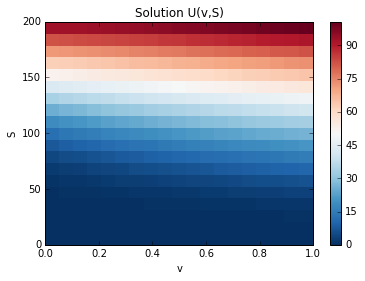

In [14]:
# Set coefficient
rho = 0.8; sigma = 0.3; r = 0.03; kappa = 2.0; theta = 0.2

K = 100.0

# Set domain: [0,S] x [0,V] x [0,T]
S = 200.0
V = 1.0
T = 1.0

# Discretize domain
M = 20
N = 20
    
U_mb, s_mb, v_mb = solve_heston_modified_backward(rho, sigma, r, kappa, theta, M, N, V, S, T, K)
X, Y = numpy.meshgrid(v_mb[:-20], s_mb[:-20])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(X, Y, U_mb[:-20,:-20], cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)

### 2.2 Monte Carlo Simulation
Monte Carlo Simulation is a broadly used class of computational algorithms that rely on repeated random sampling to obtain numerical results. 

Since the stochastic factors in Heston model are assumed to follow two correlated continuous Brownian Motions, we could generate random path to simulate the stock price evolution. Mathematically, the Brownian Motion has independent and stationary Gaussian increments:

$$
B_t \sim N(0,t),\qquad  E(B_t) = 0,\qquad Var(B_t) = t
$$

which is equiavalent to a normal random variable:

$$
B_{t+\Delta t} - B_t \sim \Delta t Z, \qquad Z\sim N(0,1)
$$

In addition, the correlation of two Brownian Motions can be re-written as:
$$
dW^2_t = \rho dW^1_t + \sqrt{1-\rho^2}\Delta t \cdot Z
$$

Therefore, the simulation method can be mathematically shown as:

$$
S_{t+1} = rS_t\cdot\Delta t + \sqrt{V_t}S_t\cdot\Delta t\cdot Z_1
$$

$$
V_{t+1} = \kappa(\theta - V_t)\cdot\Delta t + \sigma\sqrt{V_t}\cdot \Delta t\cdot Z_2
$$

$$
Z_2 = \rho Z_1 + \sqrt{1-\rho^2}Z
$$

In practice, we simulate $M$ paths of stock price. The call option price for each path at maturity is just $(S_T-K)^+$. Then we compute the average of those simulated values and discount the mean price as the current option price. 

**Code Implementation**

In [15]:
# Monte Carlo Simulation
def Heston_MonteCarlo(M, K, S0, V0, T, t, r, kappa, theta, sigma, rho, _lambda):
    N = int(numpy.round(252 * (T - t))) + 1 #time steps are evaluated per day
    dt = (T - t) / float(N)
    Sqrtdt = numpy.sqrt(dt)
    
    _k = kappa + _lambda
    _theta = (kappa * theta) / (kappa + _lambda)
    S = numpy.zeros((M, N + 1))
    S[:,0] = S[:,0] + S0
    V = numpy.zeros((M, N + 1))
    V[:,0] = V[:,0] + V0
    Call_vals = numpy.empty(M)
    for i in xrange(M):
        for j in xrange(N):
            dW1 = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
            dZ = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
            S[i,j+1] = S[i,j] + r * S[i,j] * dt + numpy.sqrt(abs(V[i,j])) * S[i,j] * dW1
            dW2 = rho * dW1 + numpy.sqrt(1.0 - rho**2) * dZ
            V[i,j+1] = V[i,j] + _k * (_theta - V[i,j]) * dt + sigma * numpy.sqrt(abs(V[i,j])) * dW2

        Call_vals[i] = max(S[i,-1] - K, 0.0) * numpy.exp(- r * (T - t))
            
    Call = numpy.mean(Call_vals)
    return Call

**Test**

In [16]:
# Test Monte Carlo
M = 5000
K = 100.0
S = 100.0
V = 0.05
T = 0.25
t = 0.0
r = 0.03
kappa = 2.0
theta = 0.2
sigma = 0.3
rho = 0.8
_lambda = 0.0
MC = Heston_MonteCarlo(M, K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda)
true = Heston_ExactSolution(rho, sigma, r, kappa, theta, _lambda, V, S, T, K)
print "Monte Carlo: ", MC
print "Exact solution: ", true

Monte Carlo:  5.95173995893
Exact solution:  6.03625703302


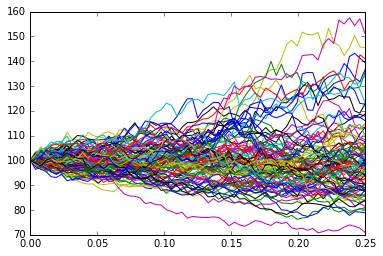

In [17]:
# Sample paths plot
M = 100
S0 = 100.0
V0 = 0.05
N = int(numpy.round(252 * (T - t))) + 1
dt = (T - t) / float(N)
Sqrtdt = numpy.sqrt(dt)
_k = kappa + _lambda
_theta = (kappa * theta) / (kappa + _lambda)
S = numpy.zeros((M, N + 1))
S[:,0] = S[:,0] + S0
V = numpy.zeros((M, N + 1))
V[:,0] = V[:,0] + V0
Call_vals = numpy.empty(M)
for i in xrange(M):
    for j in xrange(N):
        dB = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
        dW = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
        S[i,j+1] = S[i,j] + r * S[i,j] * dt + numpy.sqrt(abs(V[i,j])) * S[i,j] * dB
        dZ = rho * dB + numpy.sqrt(1.0 - rho**2) * dW
        V[i,j+1] = V[i,j] + _k*(_theta - V[i,j])*dt + sigma*numpy.sqrt(abs(V[i,j])) * dZ

x = numpy.linspace(t, T, N+1)
for i in xrange(M):
    plt.plot(x, S[i,:])
plt.show()

## 3. Error Analysis

### 3.1 Error Distribution over Domain

In [20]:
# Domain
K = 100.0; S = 200.0; V = 1.0; T = 1.0; t = 0.0
# Coefficient
r = 0.03; kappa = 2.0; theta = 0.2; sigma = 0.3; rho = 0.8; _lambda = 0.0

M = 40; N = 40

delta_s = S/(M-1)
delta_v = V/(N-1)

s = numpy.linspace(0.0, S + 20*delta_s, M+20)
v = numpy.linspace(0.0, V + 20*delta_v, N+20)

# True solution
X, Y = numpy.meshgrid(v, s)
z = numpy.array([Heston_ExactSolution(rho, sigma, r, kappa, theta, _lambda, v_t, s_t, T, K)\
                      for v_t, s_t in zip(numpy.ravel(X), numpy.ravel(Y))])
U_true = z.reshape([N+20, M+20])
#Explicit/Forward Euler
U_f, s_f, v_f = solve_heston_forward(rho, sigma, r, kappa, theta, M, N, V, S, T, K)
#Implicit/Backward Euler
U_b, s_b, v_b = solve_heston_backward(rho, sigma, r, kappa, theta, M-2, N-2, V, S, T, K)
#Modified Backward Euler
U_m, s_m, v_m = solve_heston_modified_backward(rho, sigma, r, kappa, theta, M, N, V, S, T, K)

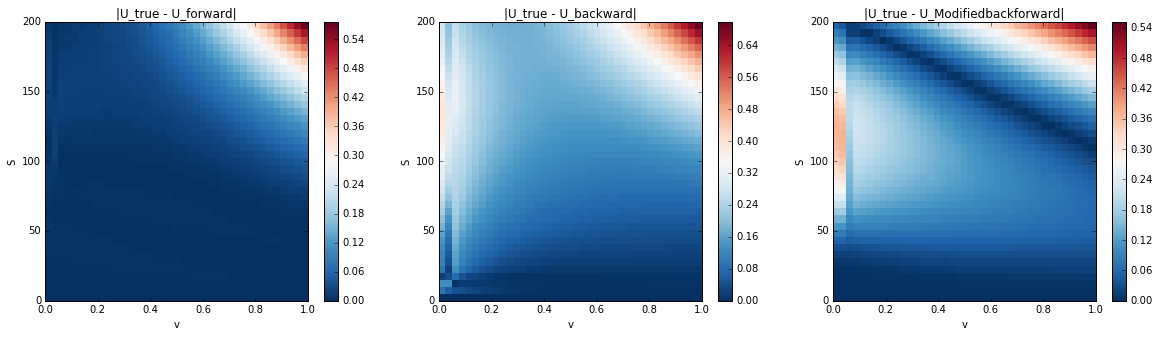

In [23]:
E, X = numpy.meshgrid(v[:-20], s[:-20])

fig = plt.figure(figsize=(20, 5))
axes = fig.add_subplot(1, 3, 1)
sol_plot = axes.pcolor(E, X, numpy.abs(U_true[:-20, :-20] - U_f[:-20,:-20]), cmap=plt.get_cmap('RdBu_r'))
axes.set_title("|U_true - U_forward|")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)


axes = fig.add_subplot(1, 3, 2)
sol_plot = axes.pcolor(E, X, numpy.abs(U_true[:-20, :-20] - U_b[:-20,:-20]), cmap=plt.get_cmap('RdBu_r'))
axes.set_title("|U_true - U_backward|")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)


axes = fig.add_subplot(1, 3, 3)
sol_plot = axes.pcolor(E, X, numpy.abs(U_true[:-20, :-20] - U_m[:-20,:-20]), cmap=plt.get_cmap('RdBu_r'))
axes.set_title("|U_true - U_Modifiedbackforward|")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)

[This is the png file of above figure]
<img src="./images/error_domain.png">

From the above figure, we observed that:
* For Forward Euler method, the higher error happens when both $v$ and $S$ large (upper right corner). 
* For the Backward Euler method, the higher error happens in two region: the upper right corner and the left boundary where $v$ is near zero.
* For Modifiend Euler method, the error distribution behaves similar to Backward Euler method, but at the left boundary, its slightly severe than the corresponding part in Backeward Euler method.

### 3.2 Order of Convergence

In [35]:
# Domain
K = 100.0; S = 200.0; V = 1.0; T = 1.0; t = 0.0
# Coefficient
r = 0.03; kappa = 2.0; theta = 0.2; sigma = 0.3; rho = 0.8; _lambda = 0.0

D = numpy.linspace(10,30,11)

error = numpy.empty([len(D), 3])
delta_s = numpy.empty(len(D))
delta_v = numpy.empty(len(D))
delta_t = numpy.empty(len(D))

# Compute the error as a function of delta_s, deta_v, delta_t
for i in xrange(len(D)):
    M = int(D[i])
    N = int(D[i])
    delta_s[i] = S/(N-1)
    delta_v[i] = V/(M-1)
    
    s = numpy.linspace(0.0, S + 20*delta_s[i], N+20)
    v = numpy.linspace(0.0, V + 20*delta_v[i], M+20)
    
    X, Y = numpy.meshgrid(v, s)
    z = numpy.array([Heston_ExactSolution(rho, sigma, r, kappa, theta, _lambda, v_t, s_t, T, K)\
                     for v_t, s_t in zip(numpy.ravel(X), numpy.ravel(Y))])
    U_true = z.reshape([N+20, M+20])
   
    #Explicit/Forward Euler
    U_f, _, _ = solve_heston_forward(rho, sigma, r, kappa, theta, M, N, V, S, T, K)
    error[i,0] = numpy.linalg.norm(delta_v[i] * (U_f[:-20, :-20] - U_true[:-20, :-20]), ord=1)
        #Implicit/Backward Euler
    U_b, _, _ = solve_heston_backward(rho, sigma, r, kappa, theta, M-2, N-2, V, S, T, K)
    error[i,1] = numpy.linalg.norm(delta_v[i] * (U_b[:-20, :-20] - U_true[:-20, :-20]), ord=1)
    #Modified Backward Euler
    U_m, _, _ = solve_heston_modified_backward(rho, sigma, r, kappa, theta, M, N, V, S, T, K)
    error[i,2] = numpy.linalg.norm(delta_v[i] * (U_m[:-20, :-20] - U_true[:-20, :-20]), ord=1)

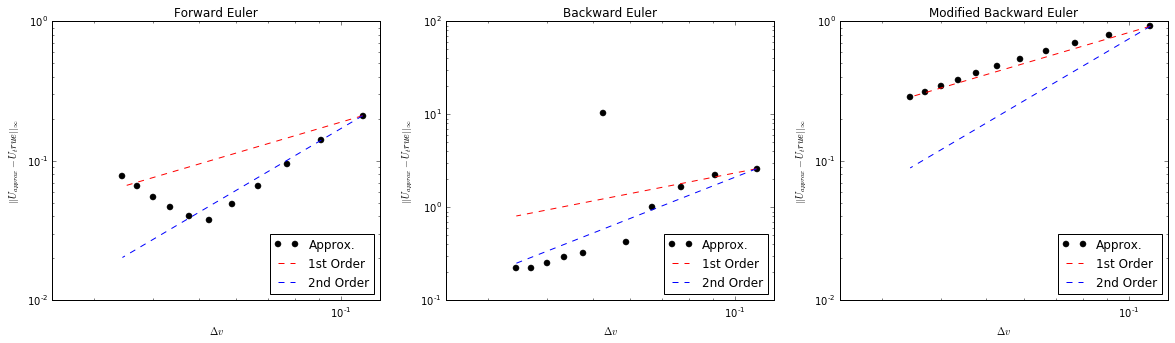

In [37]:
titles = ["Forward Euler", "Backward Euler", "Modified Backward Euler"]
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

fig = plt.figure(figsize=(20, 5))
for i in xrange(3):
    axes = fig.add_subplot(1, 3, i+1)
    axes.loglog(delta_v, error[:,i], 'ko', label="Approx.")
    axes.loglog(delta_v, order_C(delta_v[0], error[0,i], 1.0) * delta_v**1.0, 'r--', label="1st Order")
    axes.loglog(delta_v, order_C(delta_v[0], error[0,i], 2.0) * delta_v**2.0, 'b--', label="2nd Order")
    axes.legend(loc=4)
    axes.set_title(titles[i])
    plt.xlim(delta_v[-1]-0.01, delta_v[0]+0.01)
    axes.set_xlabel("$\Delta v$")
    axes.set_ylabel("$||U_{approx} - {U_true}||_{\infty}$")
plt.savefig('convergence_order.png')
plt.show()

[This is the png file of above figure]
<img src="./images/convergence_order.png">

* The order of convergence it's not quite clear for Forward Euler method. It looks like it has a second order convergence at first few points but bounds back after then. 
* For Backward Euler method, the error is oscillate around the second order convergence line. 
* For Modified Backward Euler method, compares to the other two methods, it has an obvious convergence in first order. 

### 3.3 Others
#### 3.3.1 Stability relation between Forward Euler Method and $\Delta t$ [4]
For a certain $\Delta v$, we observe that Forward Euler Method has the highest accuracy. However, this method requires a particulary small $\Delta t$ to make it work, which the one we are using is actually second order lower than those used in implicit methods. Here, we would like to present this fact by showing a relation between $\Delta t$ and the error of Forward Euler Method:

In [30]:
def test_solve_heston_forward(rho, sigma, r, kappa, theta, M, N, L, V, S, T, K):
    delta_s = S/(N-1)
    delta_v = V/(M-1)
    
    s = numpy.linspace(0.0, S + 20*delta_s, N+20)
    v = numpy.linspace(0.0, V + 20*delta_v, M+20)
    
    N = N+20
    M = M+20
    
    t = numpy.linspace(0.0, T, L)
    delta_t = t[1] - t[0]
    
    U_old = numpy.zeros(M*N)
    U_new = numpy.zeros(M*N)

    for i in range(N):
        U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)
    A_f, rhs_f = construct_A_rhs_forward(rho, sigma, r, kappa, theta, M, N, delta_v, delta_s, delta_t, v, s)
    
    for timestep in t:  
        U_new = numpy.dot(A_f, U_old)
        
        ## BC at v[-1]
        U_new += rhs_f

        ## BC at s = S[-1]
        U_new[(N-1)*M: N*M] = (2*delta_s + 4.0*U_new[(N-2)*M: (N-1)*M] - U_new[(N-3)*M: (N-2)*M])/3.0

        ## BC at v = v[0]
        for i in xrange(N):
            if i == 0:
                continue
            U_new[i*M] = ( U_old[i*M] - r*i*delta_t*U_new[(i-1)*M] + kappa*theta*delta_t*U_new[i*M + 1] / delta_v )\
                        / ( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t )
        U_old = numpy.copy(U_new)
    return numpy.reshape(U_new, [N, M]), s, v

In [31]:
# Domain
K = 100.0; S = 200.0; V = 1.0; T = 1.0; t = 0.0
# Coefficient
r = 0.03; kappa = 2.0; theta = 0.2; sigma = 0.3; rho = 0.8; _lambda = 0.0

M = 20; N = 20
delta_s = S/(N-1)
delta_v = V/(M-1)

s = numpy.linspace(0.0, S + 20*delta_s, N+20)
v = numpy.linspace(0.0, V + 20*delta_v, M+20)
X, Y = numpy.meshgrid(v, s)
z = numpy.array([Heston_ExactSolution(rho, sigma, r, kappa, theta, _lambda, v_t, s_t, T, K)\
                 for v_t, s_t in zip(numpy.ravel(X), numpy.ravel(Y))])
U_true = z.reshape([N+20, M+20])

D = [101, 501, 1001, 5001, 10001]

error_dt = numpy.empty(len(D))
delta_t = numpy.empty(len(D))

# Compute the error as a function of delta_s, deta_v, delta_t
for i in xrange(len(D)):
    L = D[i]
    delta_t[i] = T/(L-1)
   
    #Explicit/Forward Euler
    U_f, _, _ = test_solve_heston_forward(rho, sigma, r, kappa, theta, M, N, L, V, S, T, K)
    error_dt[i] = numpy.linalg.norm(delta_v * (U_f[:-20, :-20] - U_true[:-20, :-20]), ord=1)

/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: overflow encountered in multiply


In [32]:
for i in xrange(len(D)):
    print 'Delta t =', delta_t[i], 'Error = ', error_dt[i]

Delta t = 0.01 Error =  4.71929919779e+122
Delta t = 0.002 Error =  nan
Delta t = 0.001 Error =  nan
Delta t = 0.0002 Error =  0.0374760614868
Delta t = 0.0001 Error =  0.0375012962696


$\Rightarrow$ The error becomes large when $\Delta t$ is not small enough.

## 4. Conclusion

In this project, we have implemented four different methods to solve the price of Europeon Call option. As we present, they all achieve a certain level of accuracy. Also, surprisingly, the modified backward euler method works pretty well. It doesn't blow up with a wide range of discretization points (M,N) and is not true for forward and backward euler method. While in general we are satisfied with our result, there are still issues that need to be handled, such as the way that we construct the matrix makes our program becomes extremely slow as the discretization points grows; discussion in section 3.1 indicates that how we implemented the boundary condition may still have problems although it has already improved a lot compared to what we had tried; for backward euler method, it blows up at some amount of discretization points that we haven't yet figured out the pattern. 

The problems we just mentioned need works and unforturnately, we are not able to finish them in this project but would like to say that this project is really good start point to understand how numerical methods of partial differential equation would help in field of finance and also a good practice to realize that when we leave the world with dirichelet boundary conditions, things may get really hard because it will affect the solution a lot if we didn't do it in the right way.

## References
[1] Heston, S. L. (1993). A closed-form solution for options with stochastic volatility with applications to bond and currency options. Review of financial studies, 6(2), 327-343.

[2] Hull, J. C. (2015). Options, futures, and other derivatives. Pearson Education Inc.

[3] Hirsa, A. (2012). Computational methods in finance. Crc Press.

[4] Sensen, L. (2008). Finite Difference Schemes for Heston Model.